### xgboost model to predict mean player outcomes
used in conjunction with nn algs to determine mean wrc for player. Three diffrent models based on available data then combinded to create an xgb predection.

In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
function_dir = 'C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/tools'
sys.path.append(function_dir)
os.chdir('C:/Users/dalto/OneDrive/Pictures/Documents/Projects/MLB Season Model/')

In [2]:
# import data
data_15_24 = pd.read_csv('./major_leauge_preds/data/cleaned/data_15_24.csv')
df = data_15_24.drop(columns=['Unnamed: 0'])
df = df.dropna()

#### normalize data


apply z scores

In [3]:
from tools.zscore import normalize
z_score_df = normalize(df)

### xgboost model

In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

make wrc+ value the next year

In [5]:
# remove 2024 to train model bc we do not know the following year
train_z = z_score_df[z_score_df['Season'] < 2024].copy()
train_z['next_wrc+'] = np.nan # empty col


for idx in train_z.index:
    # retrive name, season
    name = train_z.loc[idx, 'Name']
    season = train_z.loc[idx, 'Season']
    # full df
    next_year_noscale = df[(df['Name'] == name) & (df['Season'] == season + 1)]
    next_year_scaled = z_score_df[(z_score_df['Name'] == name) & (z_score_df['Season'] == season + 1)]

    # add to df
    if not next_year_noscale.empty:
        train_z.loc[idx, 'next_wrc+'] = next_year_noscale['wRC+'].iloc[0]
        train_z.loc[idx, 'next_pa'] = next_year_noscale['PA'].iloc[0] # need for later anaylsis

# remove rows of nas | players retired etc.
train_z = train_z.dropna(subset=['next_wrc+'])

# display
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron altherr,2015,83.803386,88.938011,106.696917,109.230499,100.160880,108.453531,102.964885,101.884763,...,99.781669,103.037868,93.362432,111.205981,109.356964,109.841857,104.844345,88.081090,63.946339,227.0
1,aaron altherr,2016,87.484455,91.264979,105.841726,115.765286,96.704929,87.103359,98.833475,90.315507,...,90.988686,91.357501,91.456280,99.784109,100.990725,100.214769,109.467380,93.025993,119.718295,412.0
2,aaron altherr,2017,97.459324,94.128509,97.111622,106.258881,106.542076,107.075414,95.409204,104.059124,...,104.848414,98.056612,109.330507,110.896987,113.596577,113.237654,109.531036,95.095776,73.992787,285.0
3,aaron altherr,2018,90.564977,97.266110,112.293740,115.814899,87.369444,91.021666,101.857768,92.275804,...,99.975513,92.370925,106.899772,111.856531,112.750551,112.410594,113.463612,95.637806,-22.663759,66.0
5,aaron hicks,2015,96.403928,91.489408,102.878580,95.051399,96.266940,98.756712,101.035114,97.235810,...,103.803587,104.601736,93.621832,99.206091,97.688526,97.887723,96.722672,95.483790,63.755251,361.0


inject noise to next_pa
<br>
<small> I want to mimmic the accuracy of my projection model so that next_pa is not overweighted as a feature.

In [6]:
num_points = len(train_z['next_pa'])
noise = np.random.normal(loc=0, scale=75, size=num_points)  # corresponds to less than 0.8 std which is how much model misses on avg
train_z['next_pa'] = train_z['next_pa'] + noise
train_z['next_pa'] = train_z['next_pa'].clip(lower=10, upper=735)
train_z.head()

,Name,Season,PA,Age,BB%,K%,BABIP,wRC+,BsR,Off,...,xwoba,sweet_spot_percent,barrel_batted_rate,hard_hit_percent,avg_best_speed,avg_hyper_speed,whiff_percent,swing_percent,next_wrc+,next_pa
0,aaron altherr,2015,83.803386,88.938011,106.696917,109.230499,100.160880,108.453531,102.964885,101.884763,...,99.781669,103.037868,93.362432,111.205981,109.356964,109.841857,104.844345,88.081090,63.946339,270.555365
1,aaron altherr,2016,87.484455,91.264979,105.841726,115.765286,96.704929,87.103359,98.833475,90.315507,...,90.988686,91.357501,91.456280,99.784109,100.990725,100.214769,109.467380,93.025993,119.718295,436.522684
2,aaron altherr,2017,97.459324,94.128509,97.111622,106.258881,106.542076,107.075414,95.409204,104.059124,...,104.848414,98.056612,109.330507,110.896987,113.596577,113.237654,109.531036,95.095776,73.992787,195.759405
3,aaron altherr,2018,90.564977,97.266110,112.293740,115.814899,87.369444,91.021666,101.857768,92.275804,...,99.975513,92.370925,106.899772,111.856531,112.750551,112.410594,113.463612,95.637806,-22.663759,10.000000
5,aaron hicks,2015,96.403928,91.489408,102.878580,95.051399,96.266940,98.756712,101.035114,97.235810,...,103.803587,104.601736,93.621832,99.206091,97.688526,97.887723,96.722672,95.483790,63.755251,288.938134


intial selection of data before feature selection

In [7]:
train_z = train_z[train_z['PA'] > 85]
X = train_z.drop(columns=['Name', 'woba', 'next_wrc+', 'next_pa',
                           'player_id', 'pa', 'bb_percent', 'k_percent', 
                           'woba', 'BsR', 'Def', 'Season', 'swing_percent', 'BABIP',
                             'Z-Contact%', 'O-Contact%', 'Age', 'wRC+', 'WAR', 'Z-Swing%', 'Z-Contact%', 
                              'whiff_percent', 'Contact%', 'HardHit%'])
Y = train_z['next_wrc+']
xtrain, xtest, ytrain, ytest = train_test_split(X, Y, test_size=0.1, random_state=26)

train test split

In [54]:
# Calculate correlation matrix
corr = train_z.corr(numeric_only=True)

# next_wrc+ corr
corr_with_wrc = corr['next_wrc+'].sort_values(ascending=False)
print(corr_with_wrc)

next_wrc+             1.000000
next_pa               0.504303
xwoba                 0.444810
Off                   0.418847
wRC+                  0.416860
woba                  0.405514
WAR                   0.387363
avg_hyper_speed       0.345313
hard_hit_percent      0.344459
HardHit%              0.344421
PA                    0.341496
pa                    0.340904
avg_best_speed        0.339616
barrel_batted_rate    0.307658
maxEV                 0.303801
Barrel%               0.303718
BB%                   0.219636
bb_percent            0.219272
BABIP                 0.115703
sweet_spot_percent    0.110655
player_id             0.060676
O-Contact%            0.057274
Contact%              0.048962
Z-Swing%              0.040590
Z-Contact%            0.026313
BsR                   0.006537
Season               -0.005767
whiff_percent        -0.044489
SwStr%               -0.070307
swing_percent        -0.088283
K%                   -0.090299
k_percent            -0.091501
O-Swing%

In [8]:
model = xgb.XGBRegressor(n_jobs=-1, n_estimators=50000, device = "cuda", eval_metric = ['mae', 'rmse']) 

##### hyper para tuning

random search to narrow space into grid search

In [74]:
from sklearn.model_selection import RandomizedSearchCV

In [76]:
rnd_search_params = {
    'learning_rate': np.linspace(0.05, 0.2, 4),          
    'max_leaves': np.linspace(1, 40, 20, dtype=int),     
    'min_child_weight': np.linspace(1, 20, 10),         
    'subsample': np.linspace(0.3, 0.9, 7),               
    'colsample_bytree': np.linspace(0.4, 1, 7),          
    'early_stopping_rounds': np.linspace(10, 100, 10, dtype=int),  
    'max_depth': np.linspace(0, 40, 20, dtype=int)       
}

rnd_searcher = RandomizedSearchCV(model, rnd_search_params, random_state=26, n_iter=500, cv=2, n_jobs=-1, verbose=4)
rnd_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(rnd_searcher.best_params_)

Fitting 2 folds for each of 500 candidates, totalling 1000 fits
[0]	validation_0-mae:27.27240	validation_0-rmse:34.94947
[1]	validation_0-mae:26.29977	validation_0-rmse:33.69184
[2]	validation_0-mae:25.63829	validation_0-rmse:32.77871
[3]	validation_0-mae:24.93624	validation_0-rmse:31.94739
[4]	validation_0-mae:24.36509	validation_0-rmse:31.16252
[5]	validation_0-mae:24.01568	validation_0-rmse:30.73731
[6]	validation_0-mae:23.60201	validation_0-rmse:30.30791
[7]	validation_0-mae:23.22656	validation_0-rmse:29.91363


c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:14:12] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


[8]	validation_0-mae:22.95734	validation_0-rmse:29.59576
[9]	validation_0-mae:22.63938	validation_0-rmse:29.28890
[10]	validation_0-mae:22.47292	validation_0-rmse:29.14845
[11]	validation_0-mae:22.32401	validation_0-rmse:29.02150
[12]	validation_0-mae:22.10434	validation_0-rmse:28.85156
[13]	validation_0-mae:22.02929	validation_0-rmse:28.71690
[14]	validation_0-mae:21.91483	validation_0-rmse:28.61442
[15]	validation_0-mae:21.71776	validation_0-rmse:28.44736
[16]	validation_0-mae:21.69149	validation_0-rmse:28.41247
[17]	validation_0-mae:21.60057	validation_0-rmse:28.31396
[18]	validation_0-mae:21.58905	validation_0-rmse:28.29608
[19]	validation_0-mae:21.56702	validation_0-rmse:28.25455
[20]	validation_0-mae:21.56143	validation_0-rmse:28.24951
[21]	validation_0-mae:21.61301	validation_0-rmse:28.29892
[22]	validation_0-mae:21.64252	validation_0-rmse:28.27815
[23]	validation_0-mae:21.62941	validation_0-rmse:28.19997
[24]	validation_0-mae:21.62201	validation_0-rmse:28.18974
[25]	validation_

grid search

In [77]:
from sklearn.model_selection import GridSearchCV
grid_search_params = {
    'learning_rate': [0.05, 0.1],   
    'max_leaves': [8, 12, 15],
    'min_child_weight': [10, 15, 20],      
    'subsample': [0.5, 0.6, 0.7],           
    'colsample_bytree':[0.6, 0.7, 0.8],     
    'early_stopping_rounds':[30, 50, 70],
    'max_depth': [2, 3, 4]
}

In [ ]:
grid_searcher = GridSearchCV(model, grid_search_params, cv=5, n_jobs=-1, verbose=4)
grid_searcher.fit(xtrain, ytrain, eval_set=[(xtest, ytest)])
print(grid_searcher.best_params_)

In [9]:
opti_para = {'colsample_bytree': 0.7, 'early_stopping_rounds': 30, 'learning_rate': 0.05, 'max_depth': 3, 'max_leaves': 7, 'min_child_weight': 10, 'subsample': 0.6}
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

xgb.cv for detailed analysis, optimal boosting rounds

In [57]:
matrix_data = xgb.DMatrix(X, Y)
fmodel = xgb.cv(opti_para, dtrain=matrix_data, num_boost_round=1000, nfold=10, metrics= ['rmse', 'mae'], as_pandas=True, seed=26, early_stopping_rounds=30)
fmodel.head()

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:08:57] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\learner.cc:740: 
Parameters: { "early_stopping_rounds" } are not used.

  warnings.warn(smsg, UserWarning)


,train-rmse-mean,train-rmse-std,train-mae-mean,train-mae-std,test-rmse-mean,test-rmse-std,test-mae-mean,test-mae-std
0,34.464919,0.225616,25.455576,0.190053,34.439163,2.062608,25.480479,1.757797
1,33.944135,0.228607,25.045083,0.182218,33.945620,2.066466,25.085632,1.730832
2,33.608571,0.236996,24.765088,0.186190,33.636327,2.067092,24.823011,1.722099
3,33.166902,0.238392,24.408220,0.186826,33.222102,2.073235,24.487349,1.697141
4,32.735043,0.240001,24.068280,0.180159,32.805695,2.069566,24.155828,1.682092


#### opti model

In [10]:
# update model parameters
model.set_params(**opti_para)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7, device='cuda', early_stopping_rounds=30,
             enable_categorical=False, eval_metric=['mae', 'rmse'],
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=7, min_child_weight=10, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=50000,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [11]:
model.set_params(n_estimators=100, early_stopping_rounds=None)
model.fit(xtrain, ytrain)
ypreds = model.predict(xtest)

c:\Users\dalto\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:49:09] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


##### Results DF

In [13]:
results_df = xtest.copy()
results_df['Name'] = train_z.loc[xtest.index, 'Name']
results_df['Season'] = train_z.loc[xtest.index, 'Season']
results_df['next_pa'] = train_z.loc[xtest.index, 'next_pa']
results_df['pred_wrc+'] = ypreds
results_df['season_plus1_wrc+'] = ytest
results_df = results_df[['Name', 'Season', 'pred_wrc+', 'season_plus1_wrc+', 'next_pa']]
results_df['miss'] = (results_df['season_plus1_wrc+'] - results_df['pred_wrc+']).abs()
results_df.head()

,Name,Season,pred_wrc+,season_plus1_wrc+,next_pa,miss
1847,elvis andrus,2016,95.743179,105.226304,735.000000,9.483124
2336,ian desmond,2016,100.755486,70.035399,374.162420,30.720087
1234,cj cron,2019,106.647392,141.336120,100.220718,34.688728
2294,hernan perez,2018,76.958733,62.170740,322.225387,14.787993
134,adrian gonzalez,2017,79.054733,82.793155,207.803419,3.738422


##### Model Eval

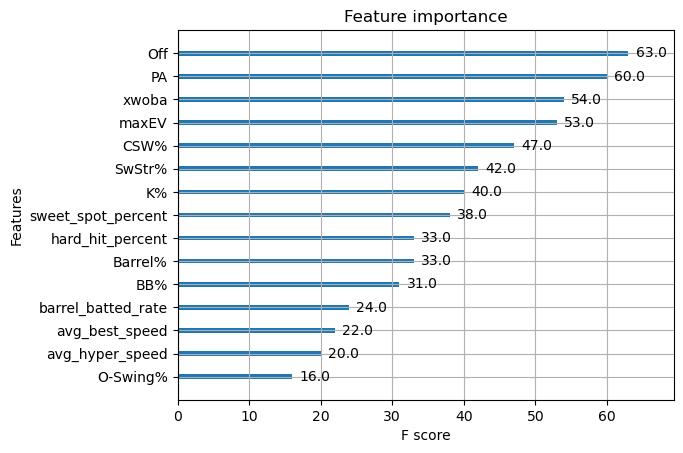

In [12]:
xgb.plot_importance(model)
plt.show()

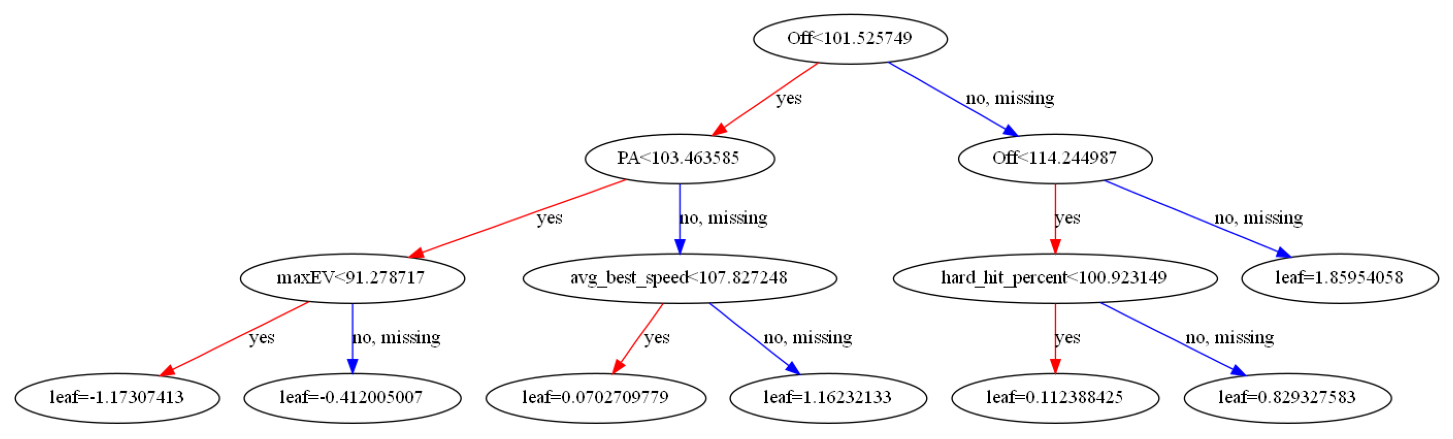

In [13]:
xgb.plot_tree(model)
plt.gcf().set_size_inches(18.5, 10.5)
plt.show()

#### Metrics

In [14]:
from sklearn.metrics import r2_score, root_mean_squared_error, mean_absolute_error

r2 = r2_score(y_true=ytest, y_pred=ypreds)
mae = mean_absolute_error(y_true=ytest, y_pred=ypreds)
rmse = root_mean_squared_error(y_true=ytest, y_pred=ypreds)

print(f"R^2: {r2} \n mae: {mae} \n rmse: {rmse}")

R^2: 0.2927938117365899 
 mae: 23.061289053321186 
 rmse: 30.404329094287796


#### 2025 Predections

In [15]:
next_pa = pd.read_csv('./major_leauge_preds/predicted_data/pa_25.csv')
next_pa = next_pa.drop(columns=['Unnamed: 0'])

In [15]:
weighted_15_24 = pd.read_csv('./major_leauge_preds/data/multi_season/weighted_15_24.csv')
weighted_15_24 = weighted_15_24.drop(columns=['Unnamed: 0'])
weighted_15_24 = normalize(weighted_15_24)

In [16]:
season = weighted_15_24[weighted_15_24['Season'] >= 2024].copy()
season = season.reset_index()
season = season.drop(columns=['index'])
season = season[train_z.drop(columns=['next_wrc+', 'next_pa']).columns]

In [18]:
season_pred = season.drop(columns=['Name', 'woba',
                           'player_id', 'pa', 'bb_percent', 'k_percent', 'BABIP',
                           'woba', 'BsR', 'Def', 'Season', 'swing_percent',
                             'Z-Contact%', 'O-Contact%', 'Age', 'wRC+', 'WAR', 'Z-Swing%', 'Z-Contact%', 
                              'whiff_percent', 'Contact%', 'HardHit%'])

In [19]:
preds_2025 = model.predict(season_pred)
preds_2025 = pd.DataFrame(preds_2025)
preds_2025['Name'] = season['Name']

In [20]:
preds_2025.to_csv('./major_leauge_preds/predicted_data/wrc_pred/reg_15_23_preds.csv')